The dataset used in this notebook is Tesla stock history from 2014 to 2017. You can find the .csv file in the project folder.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Step 0. Loading dataset

In [2]:
tesla_stocks = pd.read_csv('data/tesla_stocks.csv')

In [3]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Volume
0,2-Aug-17,318.94,327.12,311.22,325.89,13091462
1,1-Aug-17,323.00,324.45,316.13,319.57,8303102
2,31-Jul-17,335.50,341.49,321.04,323.47,8535136
3,28-Jul-17,336.89,339.60,332.51,335.07,4880414
4,27-Jul-17,346.00,347.50,326.29,334.46,8302405


In [4]:
data_to_use = tesla_stocks['Close'].values

In [5]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [6]:
scaler = StandardScaler()

In [7]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

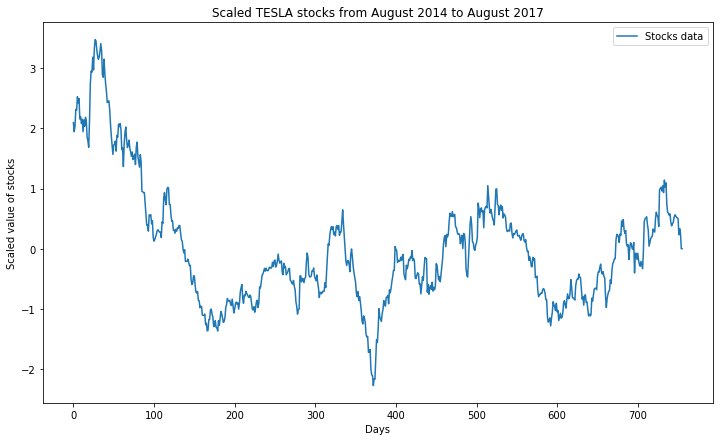

In [8]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [9]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [10]:
X, y = window_data(scaled_dataset, 7)

#### Step 1.3 Creating Training and Testing sets

In [11]:
X_train  = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


### Let's create the RNN

In [12]:
epochs = 200
batch_size = 7

In [13]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [14]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [15]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [16]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [17]:
tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)


In [18]:
tf.global_variables()

[<tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0' shape=(513, 2048) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'output_layer_weights:0' shape=(512, 1) dtype=float32_ref>,
 <tf.Variable 'output_layer_bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0' shape=(513, 2048) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam_1:0' shape=(513, 2048) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/Adam:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias/Adam_1:0' shape=(2048,) dtype=float32_ref>,
 <tf.Variable 'output_layer_weights/Adam:0' shape=(512, 1) dtype=float32_ref>,
 <tf.Variable 'output_laye

### Time to train the network

In [19]:
session =  tf.Session()

In [20]:
session.run(tf.global_variables_initializer())

In [21]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.12853291630744934
Epoch 30/200  Current loss: 0.01390756480395794
Epoch 60/200  Current loss: 0.012875549495220184
Epoch 90/200  Current loss: 0.012262540869414806
Epoch 120/200  Current loss: 0.012287182733416557
Epoch 150/200  Current loss: 0.011315606534481049
Epoch 180/200  Current loss: 0.012069053947925568


In [22]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [23]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [24]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [25]:
test_results = []
for i in range(749):
    if i >= 701:
        test_results.append(tests_new[i-701])
    else:
        test_results.append(None)

### Plotting predictions from the network

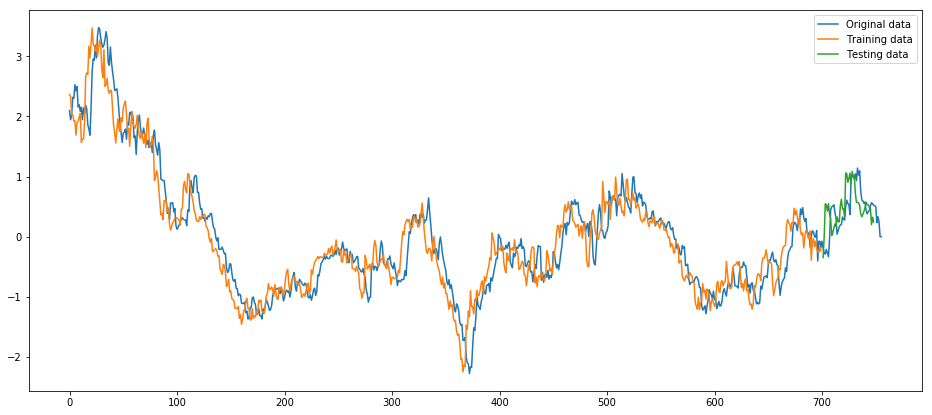

In [26]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [27]:
session.close()